cuda是否可用： True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


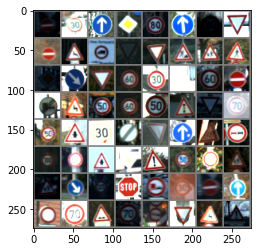

torch.Size([64, 3, 32, 32])
No entry
 Speed limit (30km/h)
 Ahead only
 Priority road
 Speed limit (80km/h)
 Ahead only
 Speed limit (80km/h)
 Yield
 No entry
 Wild animals crossing
 Vechiles over 3.5 metric tons prohibited
 Yield
 Yield
 Road work
 Children crossing
 Pedestrians
 Priority road
 Keep right
 Yield
 Speed limit (60km/h) Speed limit (30km/h)
 Right-of-way at the next intersection
 Speed limit (60km/h) No entry
 End of no passing by vechiles over 3.5 metric tons
 Double curve Speed limit (50km/h)
 Speed limit (60km/h) Speed limit (50km/h)
 Traffic signals
 Yield
 Speed limit (70km/h)
 Speed limit (50km/h)
 Right-of-way at the next intersection
 Speed limit (30km/h)
 End of all speed and passing limits
 Yield
 Ahead only
 Bicycles crossing
 No passing
 Speed limit (100km/h)
 Speed limit (50km/h)
 Right-of-way at the next intersection
 Priority road
 General caution
 Speed limit (50km/h)
 Speed limit (50km/h)
 Children crossing
 Children crossing
 Keep right
 Speed limit (12

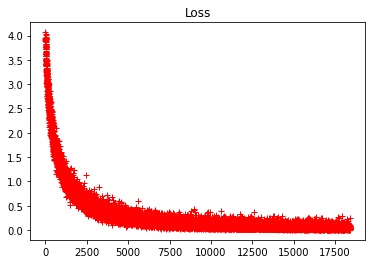

model saved
Accuracy of the network on the 10000 test images: 97 %


In [1]:
import torch
import os
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from __future__ import print_function
import torch.nn as nn
from torchvision import datasets, transforms
from torchsummary import summary 
# ======================================================================
# 设置超参数
BATCH_SIZE = 64
epochs = 30
learning_rate = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("cuda是否可用：",torch.cuda.is_available())

# ======================================================================
# 定义自己的数据集
class GTSRB(Dataset):
    base_folder = '/home/ethan95/桌面/笔记整理/data/GTSRB'

    def __init__(self, root_dir, train=False, transform=None):
        """
        Args:
            train (bool): Load trainingset or test set.
            root_dir (string): Directory containing GTSRB folder.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir

        self.sub_directory = 'trainingset' if train else 'testset'
        self.csv_file_name = 'training.csv' if train else 'test.csv'

        csv_file_path = os.path.join(
            root_dir, self.base_folder, self.sub_directory, self.csv_file_name)

        self.csv_data = pd.read_csv(csv_file_path)

        self.transform = transform

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.base_folder, self.sub_directory,
                                self.csv_data.iloc[idx, 0])
        img = Image.open(img_path)

        classId = self.csv_data.iloc[idx, 1]

        if self.transform is not None:
            img = self.transform(img)

        return img, classId

# Create Transforms
transform = transforms.Compose([ # 将多个transform组合使用
    transforms.Resize((32, 32)), # 重置图片尺寸大小
    transforms.ToTensor(),       # 将图像转换为tensor对象 
    transforms.Normalize((0.3403, 0.3121, 0.3214), # 标准化
                         (0.2724, 0.2608, 0.2669))
])
    
# 创建数据集 训练集与测试集
trainset = GTSRB(
    root_dir='/home/ethan95/桌面/笔记整理/data/GTSRB/trainingset', train=True,  transform=transform)#路径
testset = GTSRB(
    root_dir='/home/ethan95/桌面/笔记整理/data/GTSRB/testset', train=False,  transform=transform)

# 加载数据集
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 定义 43 个类别
classes = (
           'Speed limit (20km/h)\n',
           'Speed limit (30km/h)\n',
           'Speed limit (50km/h)\n',
           'Speed limit (60km/h)',
           'Speed limit (70km/h)\n',
           'Speed limit (80km/h)\n',
           'End of speed limit (80km/h)\n',
           'Speed limit (100km/h)\n',
           'Speed limit (120km/h)\n',
           'No passing\n',
           'No passing for vechiles over 3.5 metric tons\n',
           'Right-of-way at the next intersection\n',
           'Priority road\n',
           'Yield\n',
           'Stop\n',
           'No vechiles\n',
           'Vechiles over 3.5 metric tons prohibited\n',
           'No entry\n','General caution\n',
           'Dangerous curve to the left\n',
           'Dangerous curve to the right\n',
           'Double curve','Bumpy road\n','Slippery road\n',
           'Road narrows on the right\n',
           'Road work\n',
           'Traffic signals\n',
           'Pedestrians\n',
           'Children crossing\n',
           'Bicycles crossing\n',
           'Beware of ice/snow\n',
           'Wild animals crossing\n',
           'End of all speed and passing limits\n',
           'Turn right ahead\n',
           'Turn left ahead\n',
           'Ahead only\n',
           'Go straight or right\n',
           'Go straight or left\n',
           'Keep right\n',
           'Keep left\n',
           'Roundabout mandatory\n',
           'End of no passing\n',
           'End of no passing by vechiles over 3.5 metric tons\n')
# =============================================================================================
# 定义imshow函数
def imshow(img):
    img = img / 2 + 0.5     # 逆归一化
    npimg = img.numpy()     # 将张量转换成numpy数组
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose交换维度（0，1，2）转换为（1，2，0） imshow画图
    plt.show() # 显示图片

# 得到一些随机训练图像
dataiter = iter(trainloader) # 生成迭代器 
images, labels = dataiter.next()

# 显示图像
imshow(torchvision.utils.make_grid(images))

# 显示 batch_size,Channels,Width,Height
print(images.shape)

# 在一个 BATCH_SIZE 上显示随机获取的图像的类别
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))
#===========================================================================
# 用 nn.Module 来定义一个网络结构类
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # 继承 Net父类
        self.conv1 = nn.Conv2d(3, 100, 5)   # 卷积层
        self.conv1_bn = nn.BatchNorm2d(100) # batchnorm层
        self.pool = nn.MaxPool2d(2, 2)      #最大池化层
        
        self.conv2 = nn.Conv2d(100, 150, 3) # 卷积层
        self.conv2_bn = nn.BatchNorm2d(150) # batchnorm层
        
        self.conv3 = nn.Conv2d(150, 250, 1) # 卷积层
        self.conv3_bn = nn.BatchNorm2d(250) # batchnorm层
        
        self.fc1 = nn.Linear(250 * 3 * 3, 350) # 全连接层
        self.fc1_bn = nn.BatchNorm1d(350) # batchnorm层
        
        self.fc2 = nn.Linear(350, 43)    # 全连接层
        self.dropout = nn.Dropout(p=0.5) # 丢弃层

    def forward(self, x):
        '''
        Layer 1:conv1-->elu激活-->maxpool-->BatchNorm-->dropout
        '''
        x = self.pool(F.elu(self.conv1(x))) # elu激活函数
        x = self.dropout(self.conv1_bn(x))
        
        '''
        Layer 2:conv1-->elu激活-->maxpool-->BatchNorm-->dropout
        '''
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        
        '''
        Layer 3:conv1-->elu激活-->maxpool-->BatchNorm-->dropout
        '''        
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))

        '''
        Layer 4:平滑处理展成一维-->fc1-->elu激活
        '''        
        x = x.view(-1, 250 * 3 * 3) # 展成一维
        x = F.elu(self.fc1(x))

        '''
        Layer 5:BatchNorm-->dropout-->fc2
        '''        
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x


# 实例化网络并将其转移到 cuda 上
net = Net().to(device)

# 打印模型参数
summary(net,input_size=(3,32,32))
# +++++++++++++++++++++++++++++++++++===================================
# 损失函数与优化器
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) # SGD优化器
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_plot = []
# ======================================================================
# 训练网络
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    total = 0
    net.train() # 作用是启用 batch_normalization 和 drop out
    for i, data in enumerate(trainloader, 0):# 将 i, data 在训练加载器上进行迭代
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data # 将 [inputs, labels]组成列表放在data里，这里data是一个由[inputs, labels]组成的一个列表
        
        inputs, labels=inputs.to(device),labels.to(device) # 将数据转移到cuda上
        
        # 梯度清零
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # 前向计算
        _, predicted = torch.max(outputs.data, 1) # 将输出结果概率最大的作为预测值
        loss = criterion(outputs, labels) # 前向计算损失
        loss_plot.append(loss) #
        # if(i%100==0):
        #     print("loss ", loss.item())
        total += labels.size(0) # 总数累计
        correct += (predicted == labels).sum().item() # 正确率累计
        loss.backward()  # 反向传播，计算梯度
        optimizer.step() # 更新优化参数

        # 打印统计信息
        running_loss += loss.item() # 损失累计
        if i % 200 == 199:    # 每 200 mini-batches 打印一次
            print('[%d, %5d] loss: %.3f accuracy: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200,100 * correct / total ))
            
            running_loss = 0.0
            
print("结束训练！")
# ==================================================================================
# 画出损失图
plt.plot(range(len(loss_plot)),loss_plot, 'r+')#
plt.title("Loss") # 标题
plt.show() # 显示图像
PATH = '/home/ethan95/桌面/笔记整理/data/GTSRB/model.pt'# 保存路径
torch.save(net.state_dict(), PATH) # 保存网络状态
print('model saved')
# ===================================================================================
# dataiter = iter(testloader)
# images, labels = dataiter.next()
# model = torch.load(PATH)
# print images
# imshow(torchvision.utils.make_grid(images[:16]))
# print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(16)))

# 测试网络
model = Net().to(device) 
model.load_state_dict(torch.load(PATH)) #加载模型

model.eval() # 写在模型测试之前  关闭 dropout
correct = 0
total = 0
with torch.no_grad():# 此时已经不需要计算梯度，也不会进行反向传播
    for data in testloader:# 将在测试加载器上迭代
        images, labels = data
        images, labels = images.to(device), labels.to(device) # 将数据转移到cuda上
        outputs = model(images)       # 用 model获得模型的输出
        _, predicted = torch.max(outputs.data, 1)# 将输出结果概率最大的作为预测值
        total += labels.size(0) # 总数累计
        correct += (predicted == labels).sum().item()#正确率累计

# 输出测试集上的准确率        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

elu函数可以加速训练并且可以提高分类的准确率。它有以下特征：
1）elu由于其正值特性，可以像relu,lrelu,prelu一样缓解梯度消失的问题。
2）相比relu，elu存在负值，可以将激活单元的输出均值往0推近，达到
batchnormlization的效果且减少了计算量。（输出均值接近0可以减少偏移效应进而使梯
度接近于自然梯度。）
3）Lrelu和prelu虽然有负值存在，但是不能确保是一个噪声稳定的去激活状态。
4）Elu在负值时是一个指数函数，对于输入特征只定性不定量。